In [1]:
library(randomForest)
library(partykit)
library(rpart)
library(mobForest)
library(e1071)
library(nnet)
library(caret)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.

Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm

Loading required package: parallel

Loading required package: party

Loading required package: modeltools

Loading required package: stats4

Loading required package: strucchange

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich


Attaching package: ‘party’


The following objects are masked from ‘package:partykit’:

    cforest, ctree, ctree_control, edge_simple, mob, mob_control,
    node_barplot, node_bivplot, node_boxplot, node_inner, node_surv,
    node_terminal, varimp


Loading required package: lattice

Loading required package: ggplot2

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


# Méthodes de machine learning

In [31]:
data_tot = read.csv('./Donnees/Plusieurs_pays/Total.csv', header = TRUE)
data_tot = data_tot[-c(47,60)]

Création d'un nouveau dataframe sans les variables `Rating` et `Pays`, utilisé après :

In [32]:
#data = data_tot[,-c(81,82,83,84)]
data = data_tot[,-c(34:46,55:60,72:84)]
data_but_tot = data * data_tot$Nombre

## Random Forest sur la variable Points

### Extraction d'un arbre de la forêt 

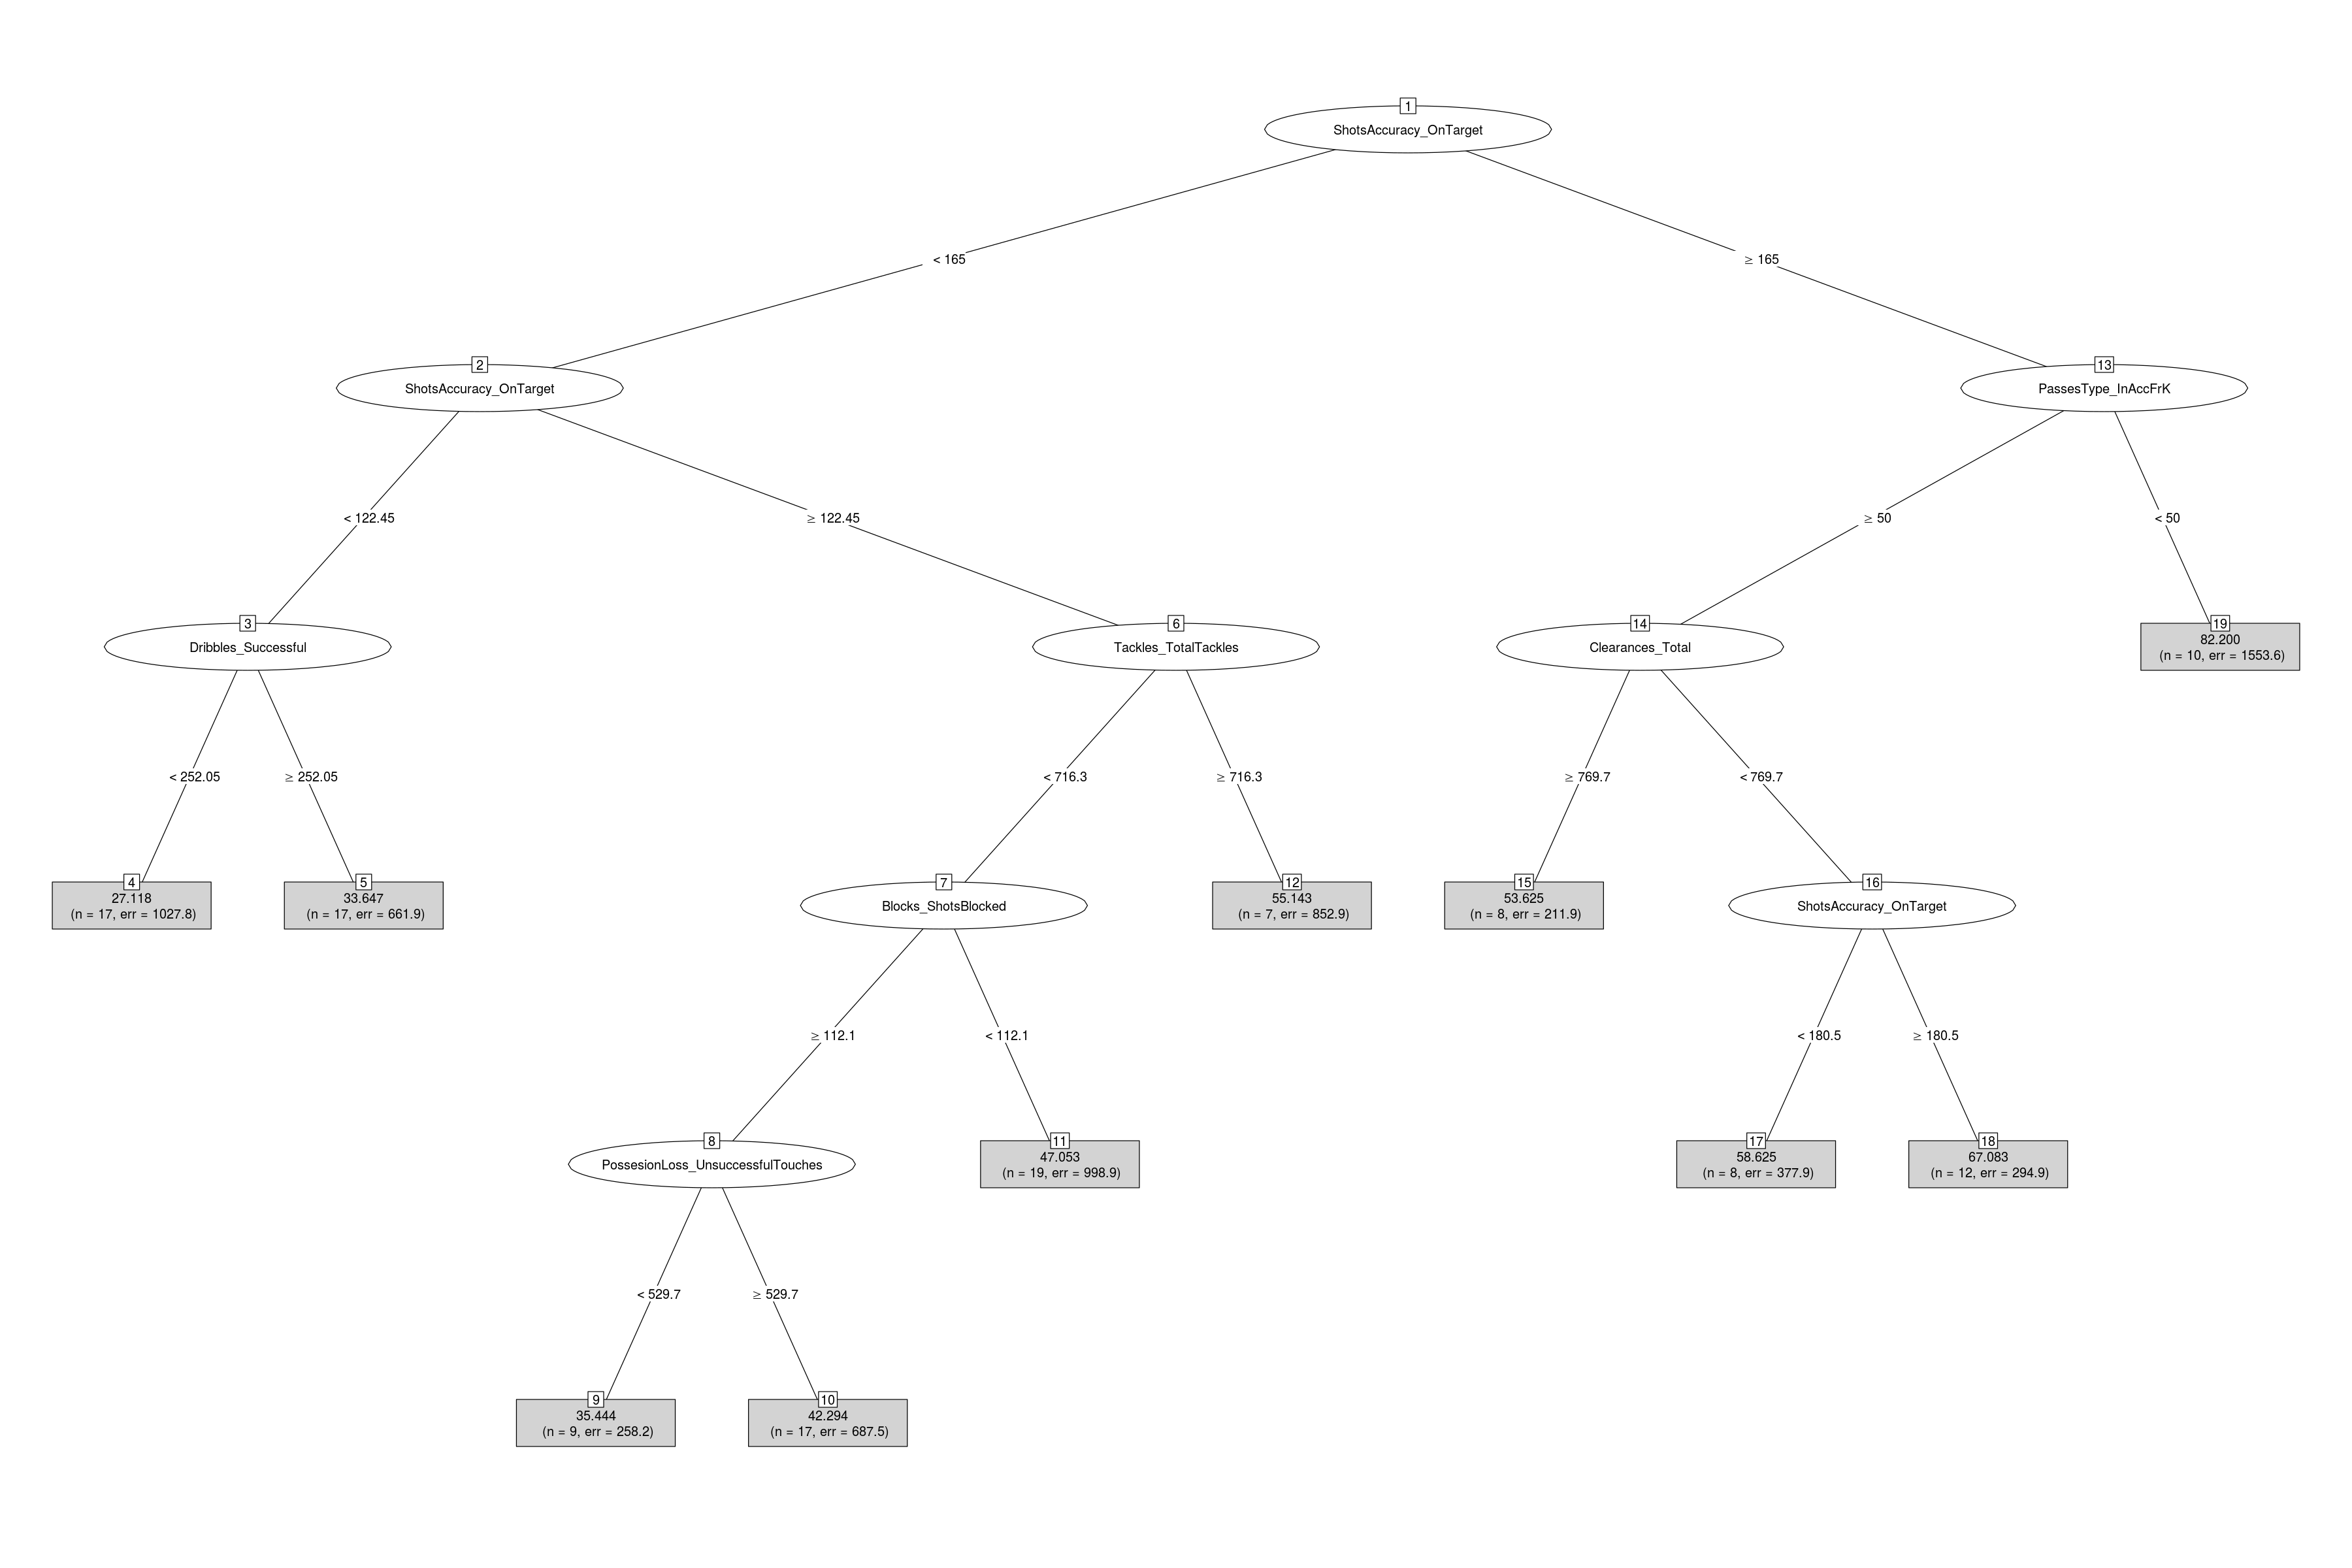

In [33]:
tree.points = rpart(data_tot$Points ~ ., data=data_but_tot, control=rpart.control(cp=0.0001))
        # le parametre cp permet de contrôler l'élagage de l'arbre

options(repr.plot.width=30, repr.plot.height=20)
plot(as.party(tree.points), type="simple")

Ici, la variable permettant de faire une première séparation, et qui est donc la plus importante est `ShotsAccuracy_OnTarget`. Elle réapparait encore après, sur chacun des deux sous arbres principaux. Cette variable est donc très importante pour la régression.

### Application du random Forest

In [34]:
#points.rf = randomForest(as.factor(data_tot$Points) ~ ., data=data_but_tot)
points.rf = randomForest(data_tot$Points ~ ., data=data_but_tot)

In [35]:
print(points.rf)


Call:
 randomForest(formula = data_tot$Points ~ ., data = data_but_tot) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 17

          Mean of squared residuals: 91.83356
                    % Var explained: 69.52


Ici on compte 10 variables importantes d'après RandomForest pour expliquer `Points`.

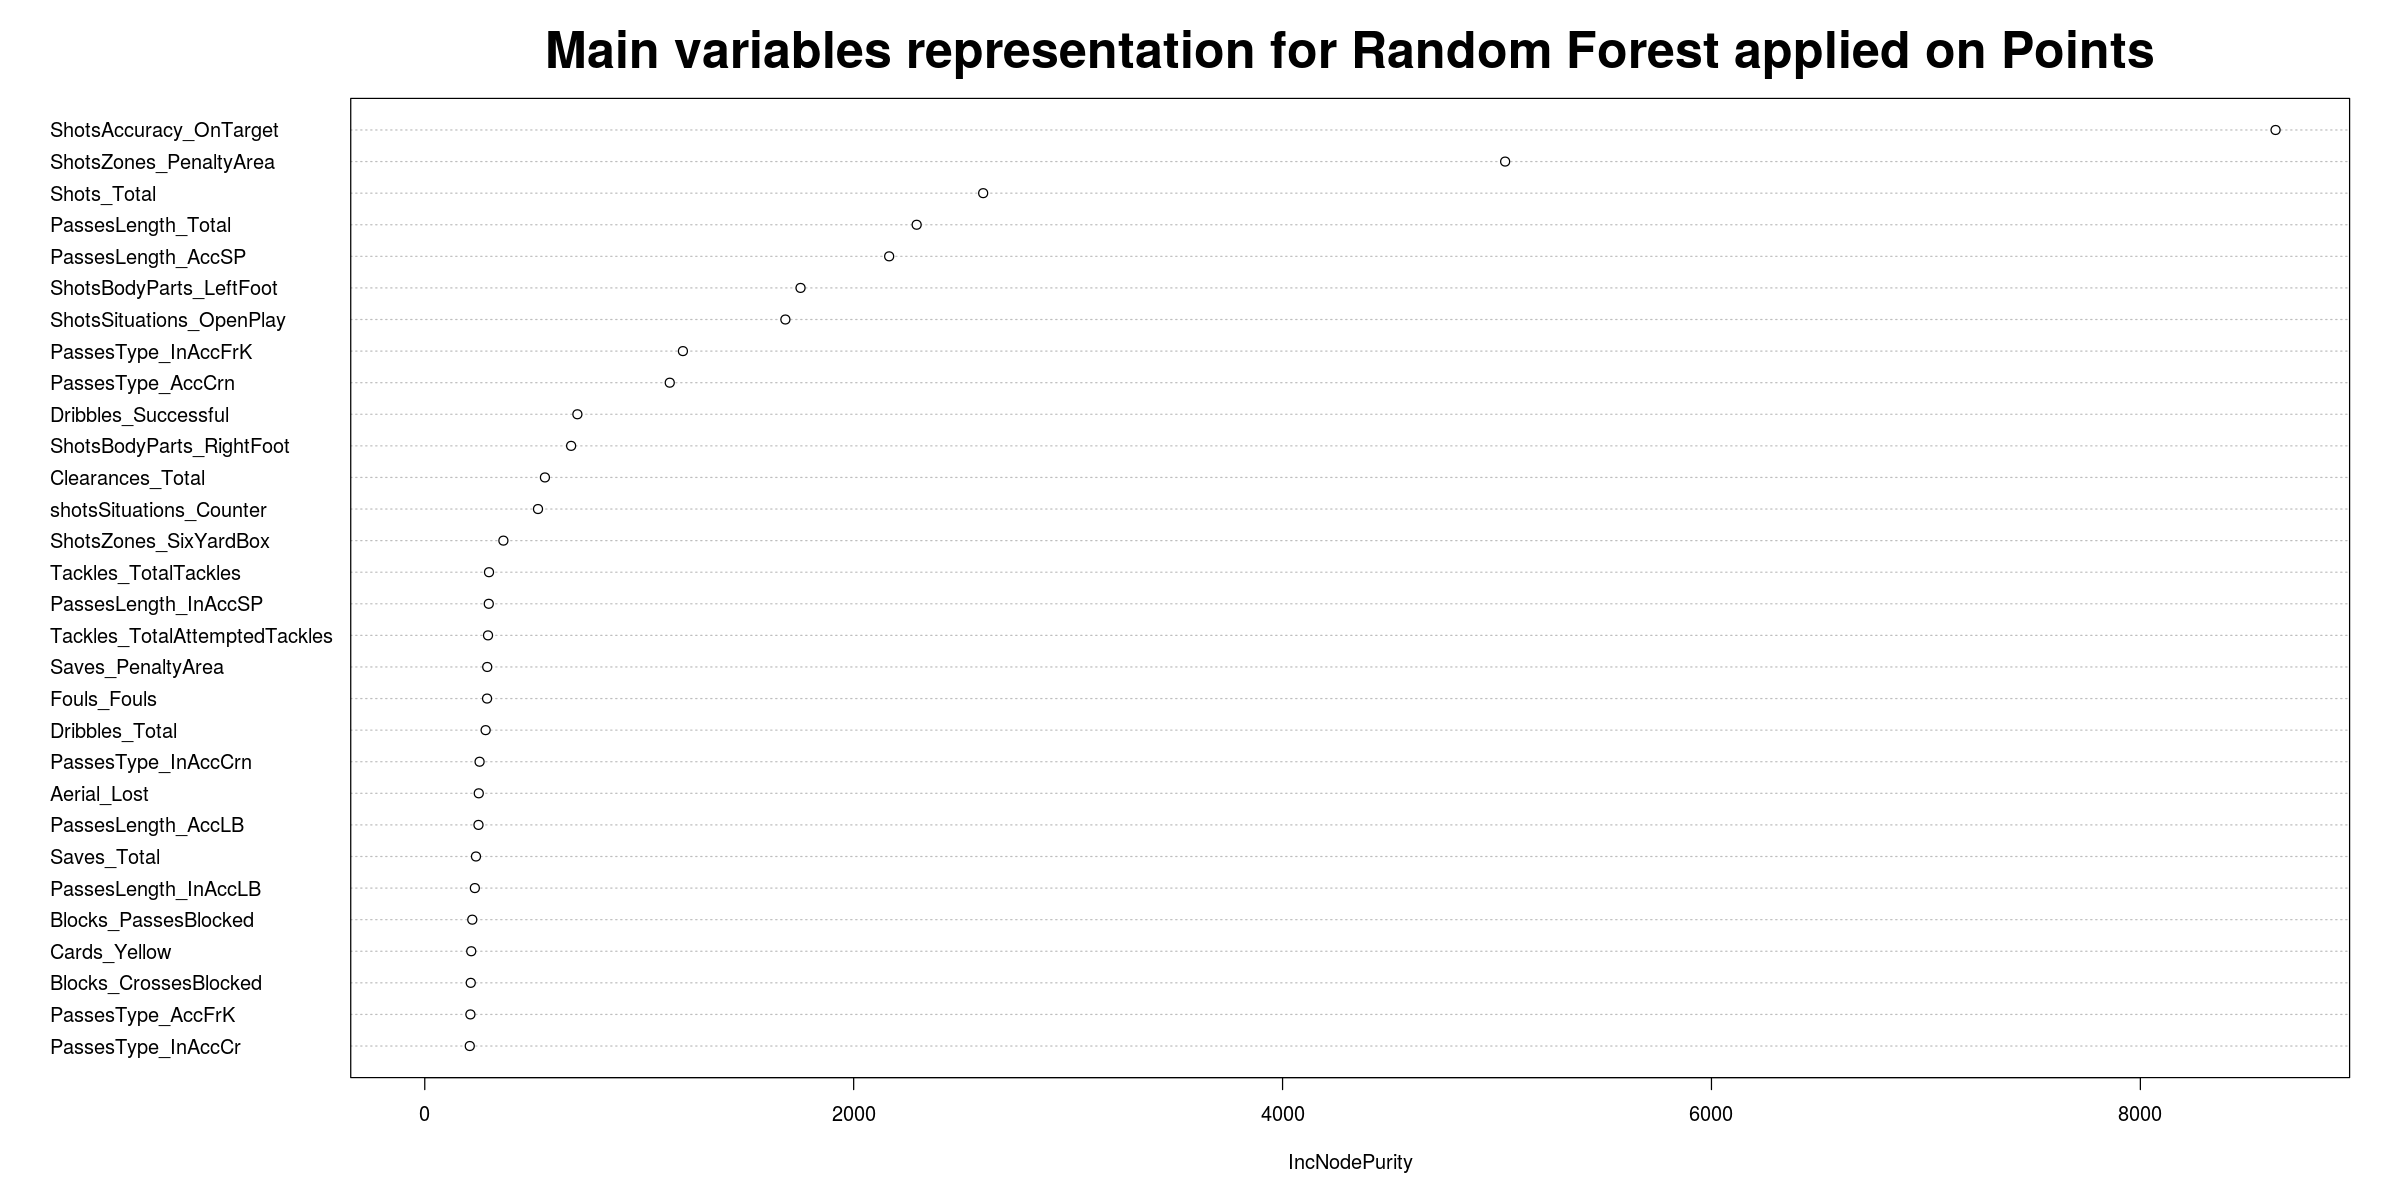

In [36]:
options(repr.plot.width=20, repr.plot.height=10)
varImpPlot(points.rf, main = "Main variables representation for Random Forest applied on Points", cex.main = 2.5)

Les principales variables mises en exergue par random forest sont `ShotsAccuracy_OnTarget`, `ShotsZones_PenaltyArea`, `Shots_Total`, `PassesLength_Total`, `PassesLength_AccSP`, `ShotsBodyParts_LeftFoot`, `ShotsSituations_OpenPlay`, `PasseType_InAccFrk` et `PassesType_AccCrn`

#### Prédiction sur le nombre de points

Il faut faire du nettoyage : en faisant de la régression ça marche, on a un $R2$ plutôt pas mal mais il fait de la régression donc on obtient des valeurs prédites non entières. Est-ce que si on récupère la partie entière des predict c'est trop faux ??

A l'inverse, quand on essaie de faire de la classification, où chaque classe = 1 entier, on prédit exactement les bonnes valeurs donc sans doute qu'on a fait du suraprentissage.

In [69]:
predict.points.rf = predict(points.rf, data_but_tot)
#predict.points.integer = as.numeric(as.character(predict.points))
#residus.points = data_tot$Points - predict.points.integer
residus.points.rf = data_tot$Points - predict.points.rf

In [70]:
predict.points.rf

Paris Saint-Germain                    Lyon                   Lille 
               85.97127                74.42907                67.48643 
            Montpellier           Saint-Etienne               Marseille 
               60.40007                59.00657                59.82067 
                   Nice                   Nimes                  Rennes 
               48.33033                54.56203                50.39097 
             Strasbourg                   Reims                  Nantes 
               50.34097                47.24633                49.76580 
                 Angers                Bordeaux                Toulouse 
               44.73857                42.66020                37.79463 
                 Monaco                   Dijon                    Caen 
               41.91463                37.05877                31.19920 
                 Amiens                Guingamp                Juventus 
               33.67153                29.26843                80.67400 
                 Napoli                Atalanta                    Roma 
               77.82943                68.82833                66.94343 
                 Torino                AC Milan                   Inter 
               62.84840                64.75533                65.71183 
                  Lazio               Sampdoria              Fiorentina 
               60.67523                52.86100                50.61607 
                Udinese                 Bologna                Sassuolo 
               42.57613                44.54260                48.73907 
                  Genoa               SPAL 2013                Cagliari 
               44.70730                41.02307                38.97843 
                 Empoli       Parma Calcio 1913               Frosinone 
               43.08393                37.57537                29.96077 
                 Chievo           Bayern Munich  RasenBallsport Leipzig 
               22.49417                80.80580                68.75360 
      Borussia Dortmund        Bayer Leverkusen              Hoffenheim 
               64.61737                61.16433                61.91813 
    Eintracht Frankfurt               Wolfsburg     Borussia M.Gladbach 
               51.40940                51.09863                52.27097 
          Werder Bremen           Hertha Berlin                Mainz 05 
               53.00727                44.12333                46.96520 
    Fortuna Duesseldorf                Augsburg              Schalke 04 
               44.53073                38.88620                36.88777 
               Freiburg           VfB Stuttgart             Hannover 96 
               32.70070                32.81640                25.75820 
              Nuernberg               Barcelona         Atletico Madrid 
               24.54250                84.13823                64.60623 
            Real Madrid                Valencia                 Sevilla 
               70.54930                58.80523                61.22047 
             Villarreal                   Eibar           Real Sociedad 
               57.73883                51.55177                49.46447 
                 Getafe                Espanyol              Celta Vigo 
               48.62307                47.25560                50.17147 
             Real Betis         Athletic Bilbao                 Leganes 
               50.37180                45.33523                42.63943 
       Deportivo Alaves                  Girona                 Levante 
               41.50633                38.81480                43.36783 
              SD Huesca          Rayo Vallecano         Real Valladolid 
               39.94583                36.02170                33.20980 
        Manchester City               Liverpool                 Chelsea 
               90.63680                87.20180                76.60460 
              Tottenham                 Arsenal          Cryst

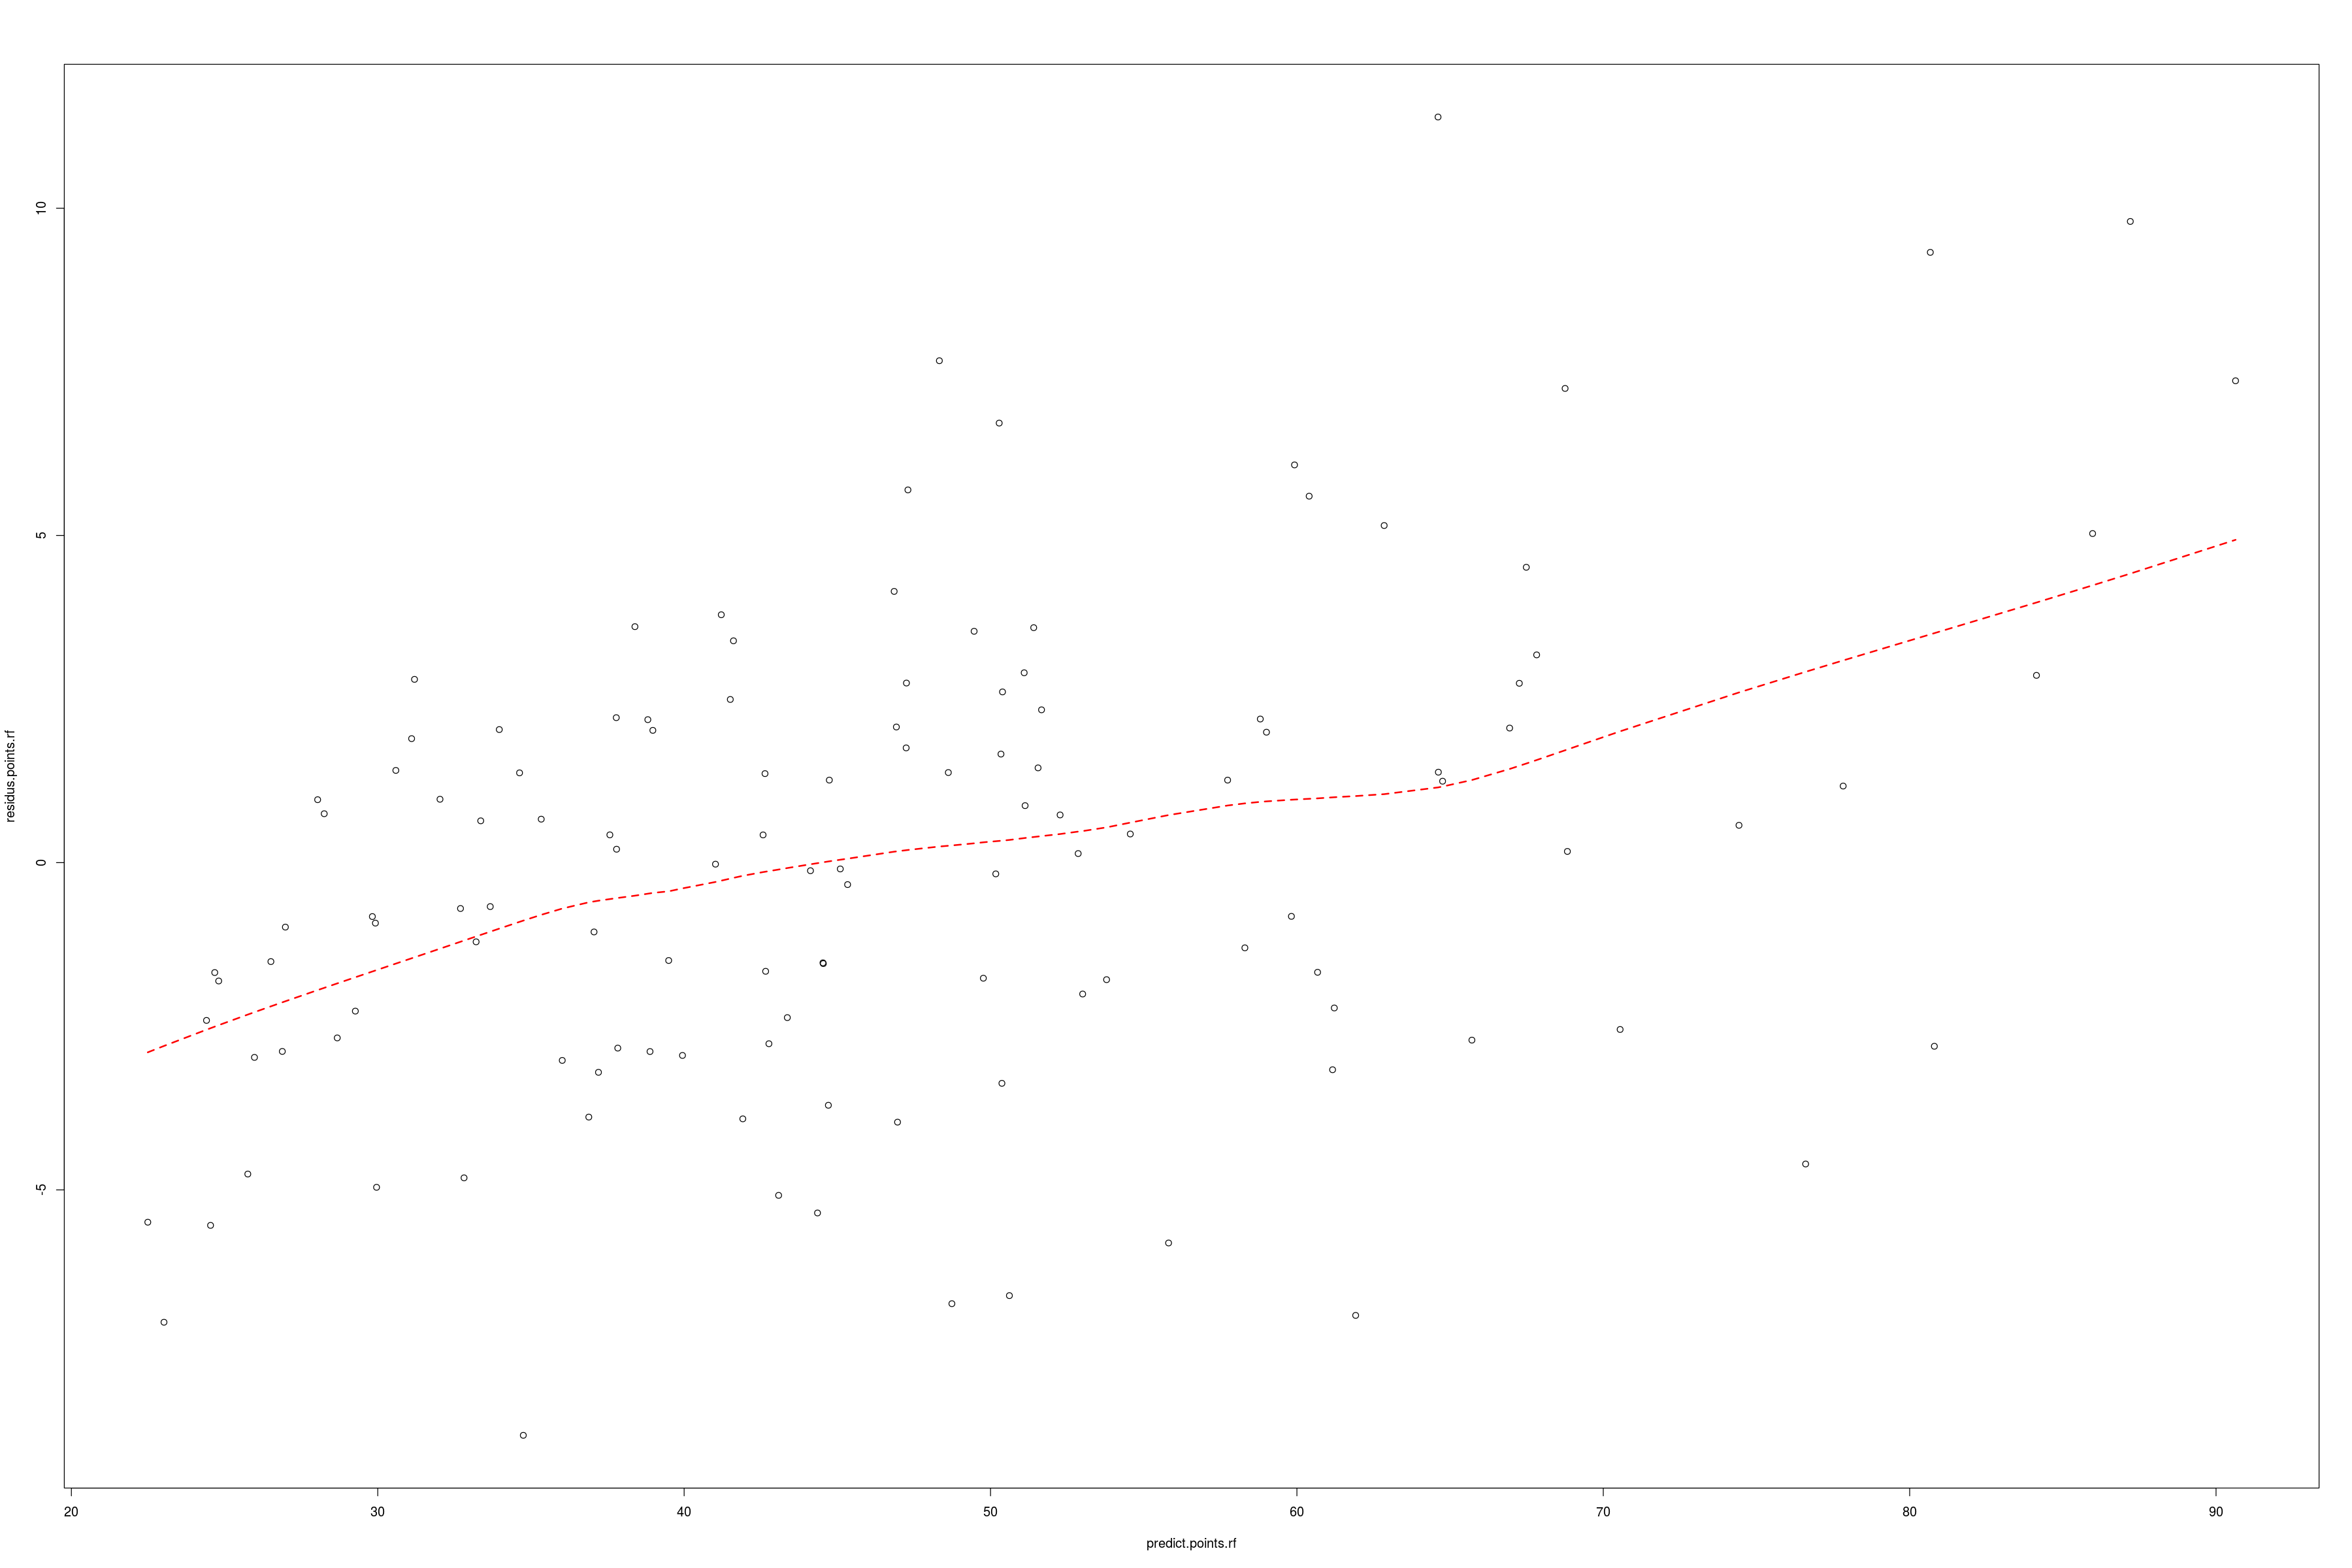

In [73]:
plot(predict.points.rf, residus.points.rf)
lines(lowess(predict.points.rf, residus.points.rf), col = 2, lty = 2, lwd = 2)

In [75]:
r.squared.points = 1-sum(residus.points.rf**2)/(length(data_tot$Points)*var(data_tot$Points))
r.squared.points

[1] 0.9559752

In [77]:
sum(residus.points.rf**2)/124*300

[1] 4011.992

In [78]:
predict.points.rf

Paris Saint-Germain                    Lyon                   Lille 
               85.97127                74.42907                67.48643 
            Montpellier           Saint-Etienne               Marseille 
               60.40007                59.00657                59.82067 
                   Nice                   Nimes                  Rennes 
               48.33033                54.56203                50.39097 
             Strasbourg                   Reims                  Nantes 
               50.34097                47.24633                49.76580 
                 Angers                Bordeaux                Toulouse 
               44.73857                42.66020                37.79463 
                 Monaco                   Dijon                    Caen 
               41.91463                37.05877                31.19920 
                 Amiens                Guingamp                Juventus 
               33.67153                29.26843                80.67400 
                 Napoli                Atalanta                    Roma 
               77.82943                68.82833                66.94343 
                 Torino                AC Milan                   Inter 
               62.84840                64.75533                65.71183 
                  Lazio               Sampdoria              Fiorentina 
               60.67523                52.86100                50.61607 
                Udinese                 Bologna                Sassuolo 
               42.57613                44.54260                48.73907 
                  Genoa               SPAL 2013                Cagliari 
               44.70730                41.02307                38.97843 
                 Empoli       Parma Calcio 1913               Frosinone 
               43.08393                37.57537                29.96077 
                 Chievo           Bayern Munich  RasenBallsport Leipzig 
               22.49417                80.80580                68.75360 
      Borussia Dortmund        Bayer Leverkusen              Hoffenheim 
               64.61737                61.16433                61.91813 
    Eintracht Frankfurt               Wolfsburg     Borussia M.Gladbach 
               51.40940                51.09863                52.27097 
          Werder Bremen           Hertha Berlin                Mainz 05 
               53.00727                44.12333                46.96520 
    Fortuna Duesseldorf                Augsburg              Schalke 04 
               44.53073                38.88620                36.88777 
               Freiburg           VfB Stuttgart             Hannover 96 
               32.70070                32.81640                25.75820 
              Nuernberg               Barcelona         Atletico Madrid 
               24.54250                84.13823                64.60623 
            Real Madrid                Valencia                 Sevilla 
               70.54930                58.80523                61.22047 
             Villarreal                   Eibar           Real Sociedad 
               57.73883                51.55177                49.46447 
                 Getafe                Espanyol              Celta Vigo 
               48.62307                47.25560                50.17147 
             Real Betis         Athletic Bilbao                 Leganes 
               50.37180                45.33523                42.63943 
       Deportivo Alaves                  Girona                 Levante 
               41.50633                38.81480                43.36783 
              SD Huesca          Rayo Vallecano         Real Valladolid 
               39.94583                36.02170                33.20980 
        Manchester City               Liverpool                 Chelsea 
               90.63680                87.20180                76.60460 
              Tottenham                 Arsenal          Cryst

## SVM sur la variable Points

In [37]:
svm.points = svm(data_tot$Points ~ ., data=data_but_tot, kernel="radial")

In [38]:
svm.predict.points = predict(svm.points, data_but_tot)

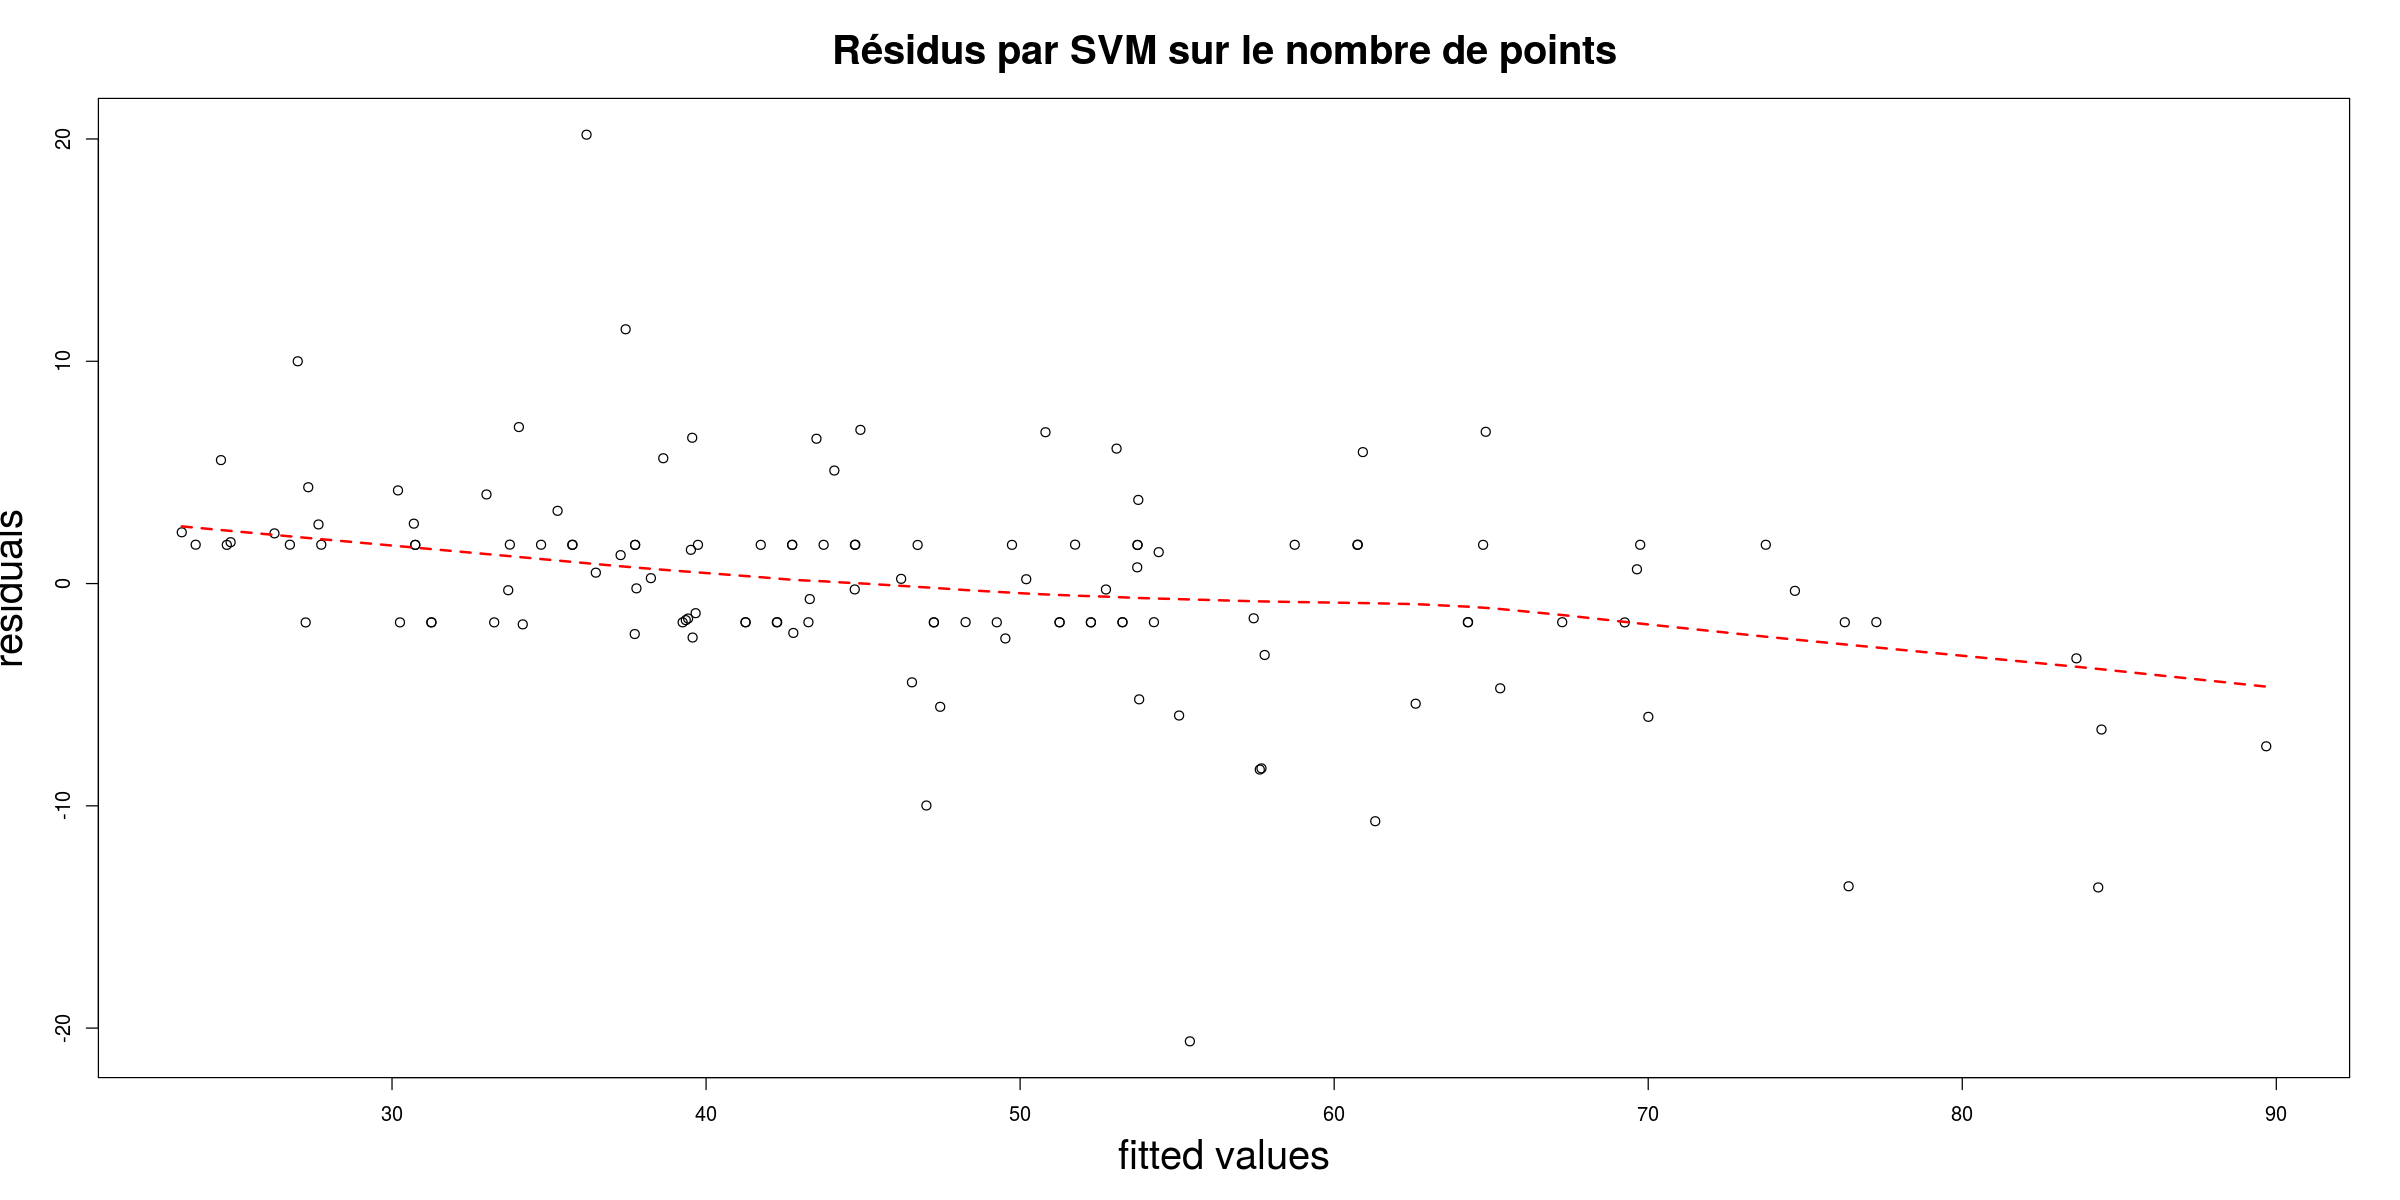

In [44]:
residus.svm.points = svm.predict.points - data_tot$Points
plot(svm.predict.points, residus.svm.points, main = "Résidus par SVM sur le nombre de points", 
     cex.main = 2, xlab = "fitted values", ylab = "residuals", cex.lab = 2)
lines(lowess(svm.predict.points, residus.svm.points), col = 2, lty = 2, lwd = 2)

In [45]:
R2svm.points = 1 - sum(residus.svm.points ^ 2)/(length(data_tot$Points)*var(data_tot$Points))

In [46]:
R2svm.points

[1] 0.9238677

Ici le $R^2$ est très bon, car proche de 1, et les résidus sont corrects aussi.

## NNET

In [95]:
nnet.points = avNNet(data_but_tot, data_tot$Points, size=14)

Fitting Repeat 1 

# weights:  967
initial  value 307117.614582 
final  value 304182.000000 
converged
Fitting Repeat 2 

# weights:  967
initial  value 311148.793019 
final  value 304182.000000 
converged
Fitting Repeat 3 

# weights:  967
initial  value 309562.051931 
final  value 304182.000000 
converged
Fitting Repeat 4 

# weights:  967
initial  value 310788.728218 
final  value 304182.000000 
converged
Fitting Repeat 5 

# weights:  967
initial  value 313469.651885 
final  value 304182.000000 
converged


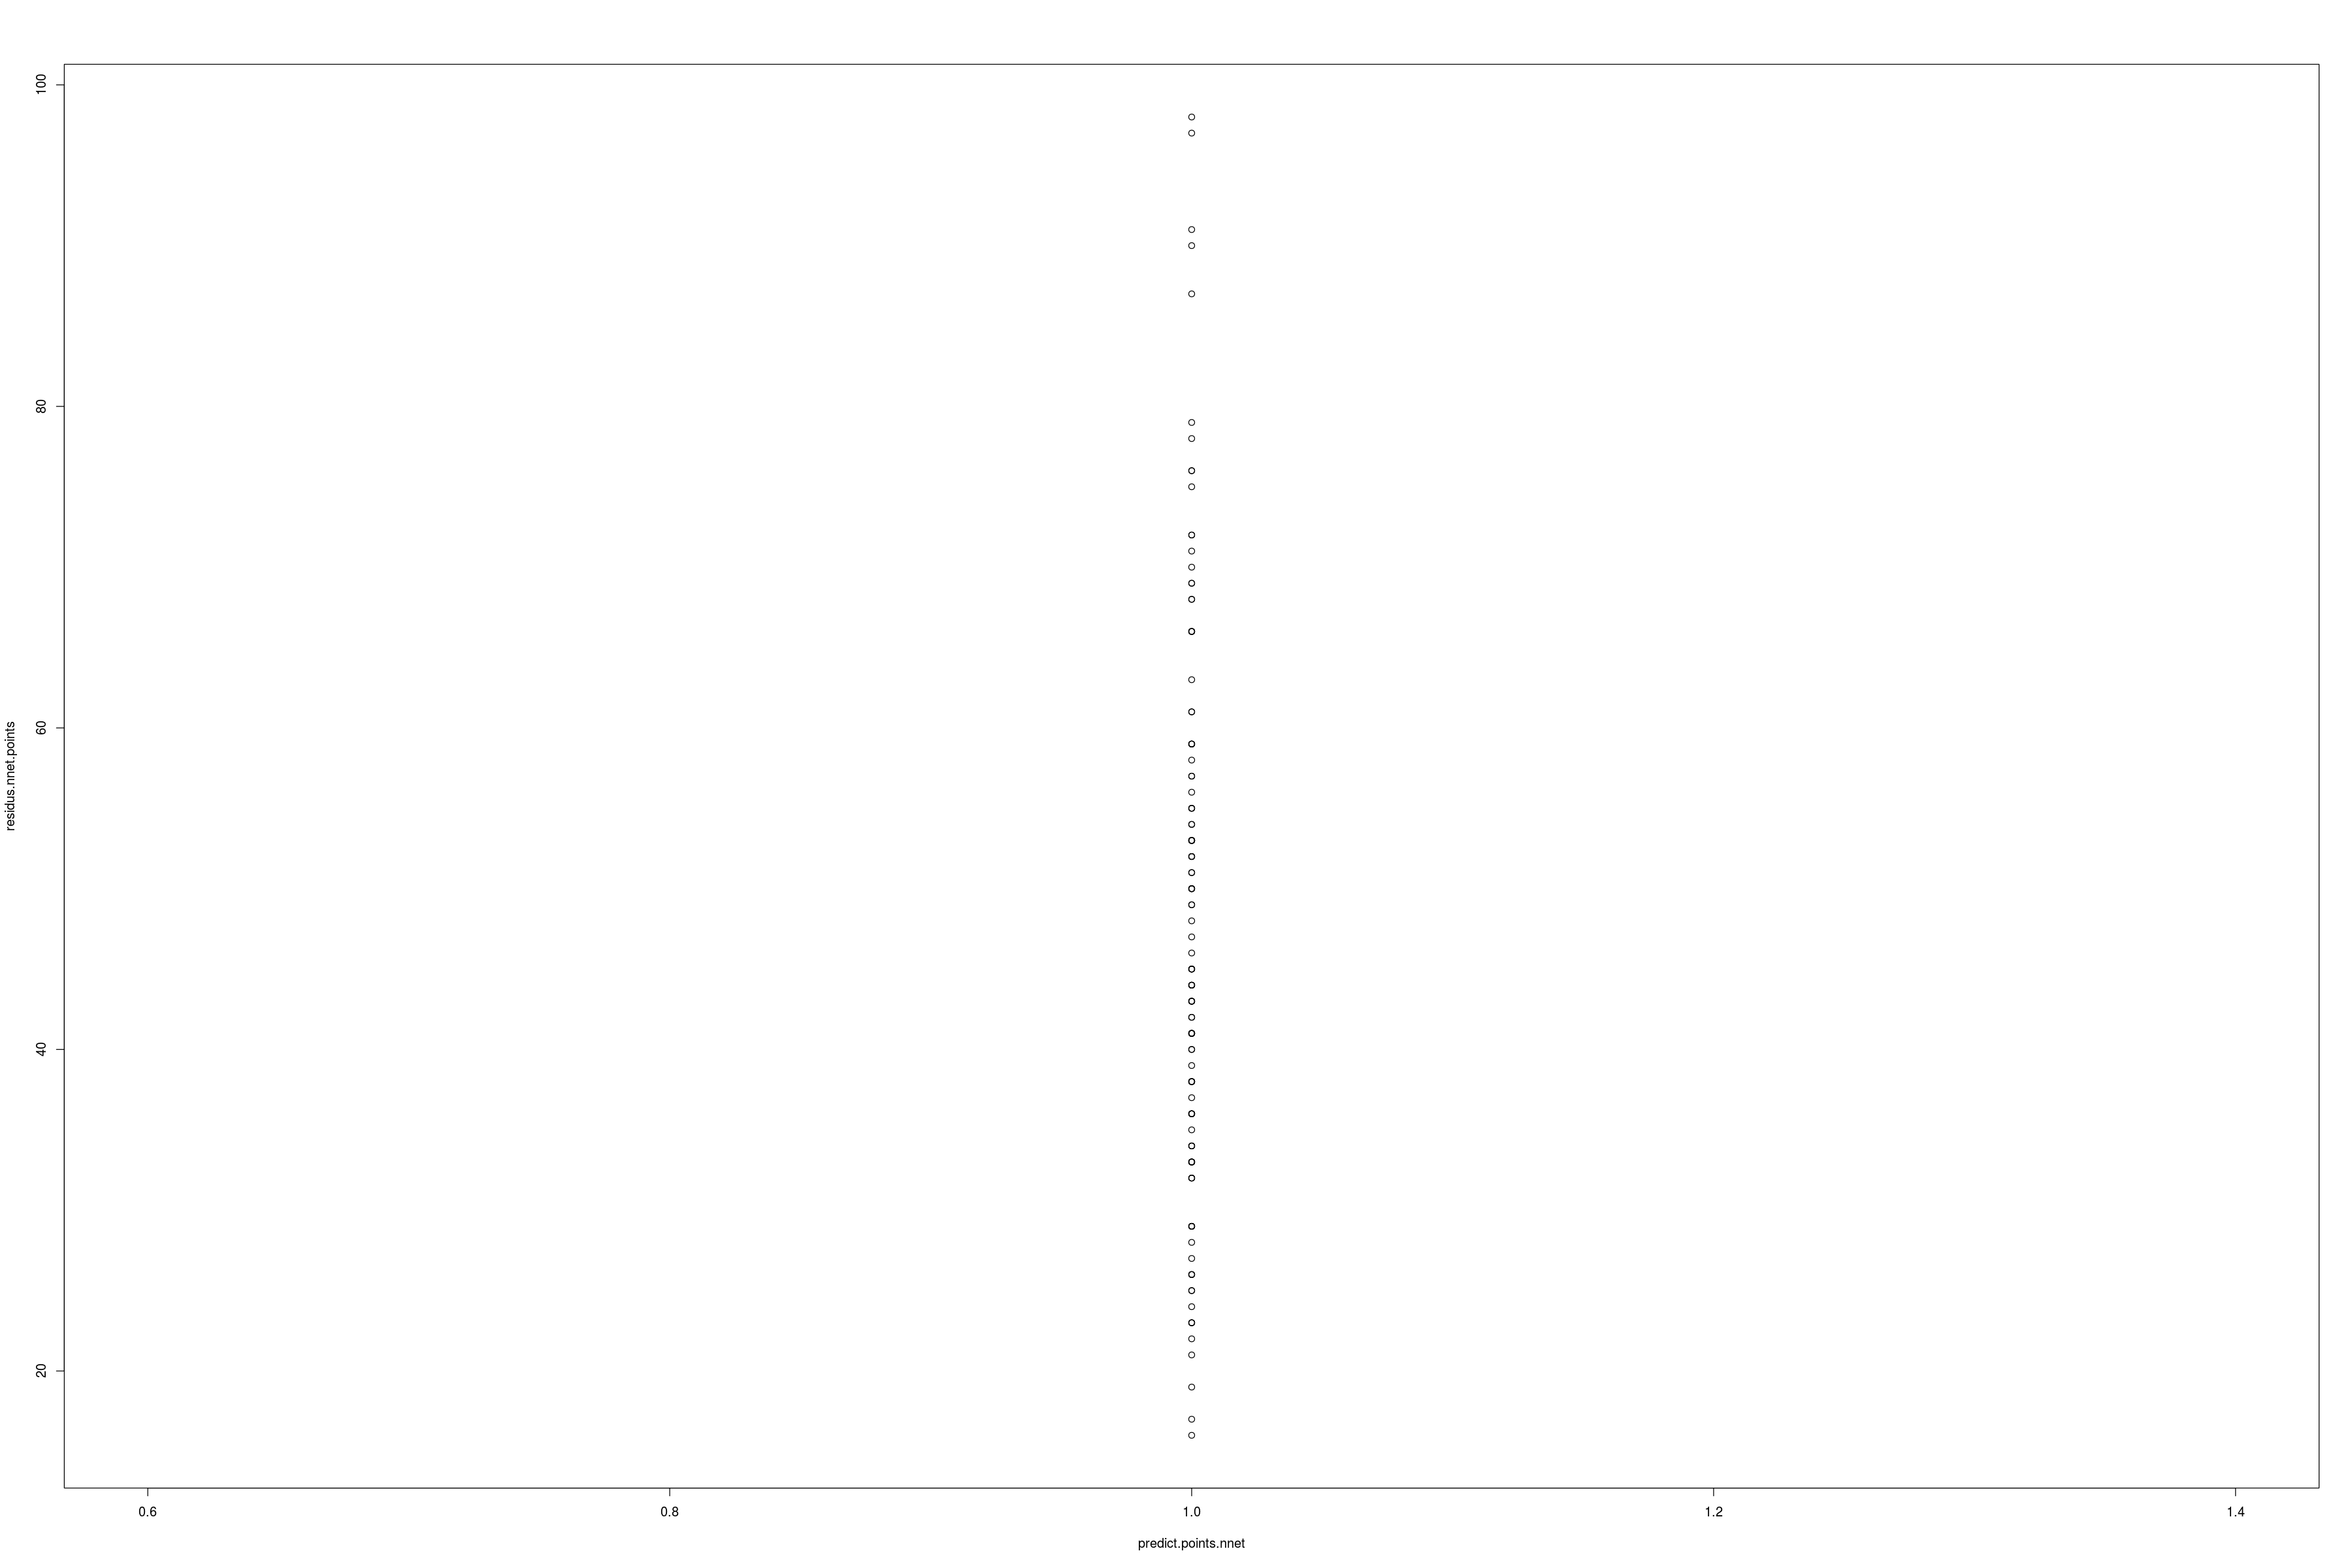

In [98]:
predict.points.nnet = predict(nnet.points, data, type="raw")
residus.nnet.points = data_tot$Points
plot(predict.points.nnet, residus.nnet.points)

In [99]:
predict.points.nnet

Paris Saint-Germain                    Lyon                   Lille 
                      1                       1                       1 
            Montpellier           Saint-Etienne               Marseille 
                      1                       1                       1 
                   Nice                   Nimes                  Rennes 
                      1                       1                       1 
             Strasbourg                   Reims                  Nantes 
                      1                       1                       1 
                 Angers                Bordeaux                Toulouse 
                      1                       1                       1 
                 Monaco                   Dijon                    Caen 
                      1                       1                       1 
                 Amiens                Guingamp                Juventus 
                      1                       1                       1 
                 Napoli                Atalanta                    Roma 
                      1                       1                       1 
                 Torino                AC Milan                   Inter 
                      1                       1                       1 
                  Lazio               Sampdoria              Fiorentina 
                      1                       1                       1 
                Udinese                 Bologna                Sassuolo 
                      1                       1                       1 
                  Genoa               SPAL 2013                Cagliari 
                      1                       1                       1 
                 Empoli       Parma Calcio 1913               Frosinone 
                      1                       1                       1 
                 Chievo           Bayern Munich  RasenBallsport Leipzig 
                      1                       1                       1 
      Borussia Dortmund        Bayer Leverkusen              Hoffenheim 
                      1                       1                       1 
    Eintracht Frankfurt               Wolfsburg     Borussia M.Gladbach 
                      1                       1                       1 
          Werder Bremen           Hertha Berlin                Mainz 05 
                      1                       1                       1 
    Fortuna Duesseldorf                Augsburg              Schalke 04 
                      1                       1                       1 
               Freiburg           VfB Stuttgart             Hannover 96 
                      1                       1                       1 
              Nuernberg               Barcelona         Atletico Madrid 
                      1                       1                       1 
            Real Madrid                Valencia                 Sevilla 
                      1                       1                       1 
             Villarreal                   Eibar           Real Sociedad 
                      1                       1                       1 
                 Getafe                Espanyol              Celta Vigo 
                      1                       1                       1 
             Real Betis         Athletic Bilbao                 Leganes 
                      1                       1                       1 
       Deportivo Alaves                  Girona                 Levante 
                      1                       1                       1 
              SD Huesca          Rayo Vallecano         Real Valladolid 
                      1                       1                       1 
        Manchester City               Liverpool                 Chelsea 
                      1                       1                       1 
              Tottenham                 Arsenal          Cryst